# Определение возраста покупателей по фотографии

## Исследовательский анализ данных

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

In [1]:
# Загрузим библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [ ]:
# Загрузим данные

path = '/datasets/faces/'
data = pd.read_csv(path + 'labels.csv')

In [ ]:
# Изучим данные

data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


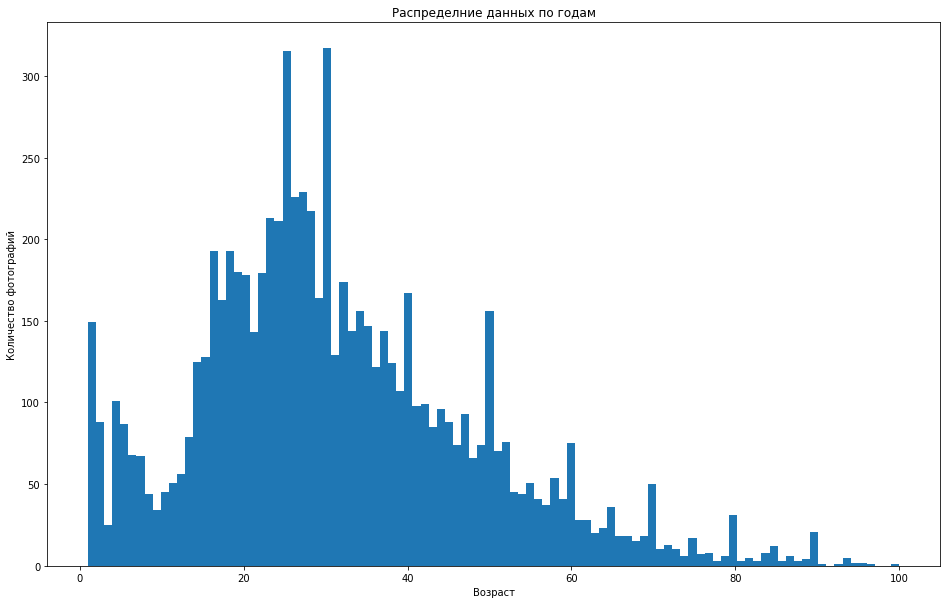

In [ ]:
#Построим гистограмму

fig, ax = plt.subplots(figsize=(16, 10))
plt.hist(data.real_age, bins=100);
ax.set_title('Распределние данных по годам');
ax.set(xlabel='Возраст', ylabel='Количество фотографий');

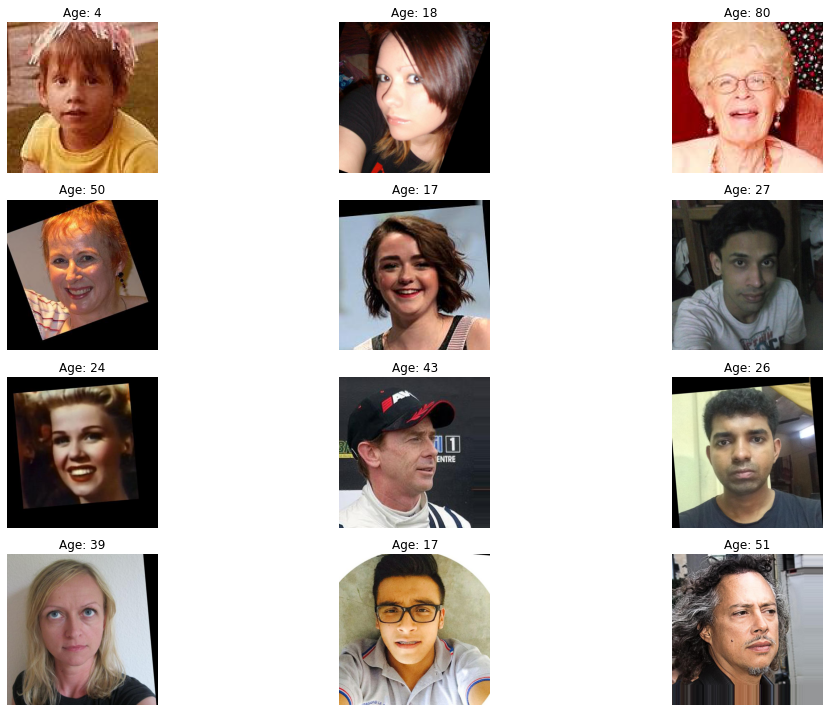

In [ ]:
#Выведем примеры фотографиц с указанием возраста

image_dir = path + 'final_files/'
image_paths = [os.path.join(image_dir, filename) for filename in data['file_name']]
images = plt.figure(figsize=(16, 10))

for i in range(12):
    image = plt.imread(image_paths[i])
    label = data['real_age'][i]
    ax = images.add_subplot(4, 3, i+1)
    ax.imshow(image)
    ax.set_title('Age: {}'.format(label))
    ax.axis('off')
plt.tight_layout()
plt.show()

### Вывод

* Датасет содержит 7591 фотографии людей. Для каждой фотографии приведен возраст.
* Средний возраст людей - 31 год. 75% фотографий в датесете людямвозрастом до 41 года. Это может повлиять на работу модели.
* На большинстве фотографий хорошо различимы черты лица.
* На гистограмме наблюдаются аномальные значения в года кратные 5. Это может быть объяснено тем, что настоящий возраст людей был неизвестен человеку, размечавшему датасет, и он округлял его.

## Обучение модели

def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1/255.
    )

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        subset='training',
        seed=12345
    )

    return train_gen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.
    )

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path+'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        subset='validation',
        seed=12345
    )

    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None,
                validation_steps=None):
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True
    )

    return model

Train for 178 steps, validate for 60 steps

Epoch 1/10
178/178 - 53s - loss: 258.8750 - mae: 11.5137 - val_loss: 773.6102 - val_mae: 22.8422

Epoch 2/10
178/178 - 38s - loss: 83.6987 - mae: 6.9254 - val_loss: 797.6342 - val_mae: 23.2530

Epoch 3/10
178/178 - 37s - loss: 52.0400 - mae: 5.4513 - val_loss: 335.6834 - val_mae: 13.4418

Epoch 4/10
178/178 - 37s - loss: 37.0932 - mae: 4.6327 - val_loss: 147.1560 - val_mae: 9.4395

Epoch 5/10
178/178 - 35s - loss: 27.2359 - mae: 3.9521 - val_loss: 86.9342 - val_mae: 7.0152

Epoch 6/10
178/178 - 35s - loss: 21.1171 - mae: 3.5031 - val_loss: 91.7056 - val_mae: 7.0591

Epoch 7/10
178/178 - 35s - loss: 16.9397 - mae: 3.1370 - val_loss: 82.2724 - val_mae: 6.6985

Epoch 8/10
178/178 - 35s - loss: 12.5565 - mae: 2.7044 - val_loss: 81.2010 - val_mae: 6.6272

Epoch 9/10
178/178 - 35s - loss: 10.4857 - mae: 2.4450 - val_loss: 69.6911 - val_mae: 6.3686

Epoch 10/10
178/178 - 35s - loss: 8.9545 - mae: 2.2733 - val_loss: 67.4677 - val_mae: 6.1784

60/60 - 9s - loss: 67.4677 - mae: 6.1784
Test MAE: 6.1784

## Выводы

* В ходе изучения датасета было показано: 1)датасет содержит 7591 фотографии людей. Для каждой фотографии приведен возраст.
2) Средний возраст людей - 31 год. 75% фотографий в датесете людямвозрастом до 41 года. Это может повлиять на работу модели.
3) На большинстве фотографий хорошо различимы черты лица. Была построена гистограмма где наблюдаются аномальные значения в года кратные 5. Это может быть объяснено тем, что настоящий возраст людей был неизвестен человеку, размечавшему датасет, и он округлял его.



* Была использована предварительно обученная модель ResNet-50 для анализа изображений и извлечения характеристик из них. Она добавляет дополнительные слои для усреднения этих характеристик и предсказания возраста, используя функцию активации ReLU. Для настройки параметров модели используется оптимизатор Adam, а ее качество оценивается с помощью среднего абсолютного отклонения.



* Полученная модель показала среднюю абсолютную ошибку (MAE) в размере 6.18 на тестовых данных. Это означает, что предсказанный возраст может отличаться от реального возраста человека на 6 лет. Для лиц в возрасте до 24 лет рекомендуется дополнительно проверять документы, подтверждающие возраст, даже если модель указывает на возраст, превышающий 18 лет.



* Для более точных рекомендаций о продаже дополнительных товаров можно ориентироваться на возраст после 25-30 лет, так как ошибка в 6 лет более значительна для более молодых возрастных групп. Модель была обучена в течение 10 эпох с параметром learning rate = 0.0001. Качество модели на валидационной выборке показало, что ее параметры хорошо настроились после первых 4 эпох обучения, а дальнейшие улучшения шли более медленными темпами.